# Hierarchy Classification

Queremos implementar un solo modelo que incorpore jerarquías (por ejemplo, BENIGN → Web Attack → Subtipo de Web Attack), podemos usar un modelo multicapa jerárquico:

Entrenaremos un modelo con múltiples salidas, donde cada salida represente un nivel de la jerarquía.

Ejemplo:

    - Nivel 1: BENIGN vs MALICIOUS.

    - Nivel 2: Si es MALICIOUS, clasifica entre DDoS, PortScan, y WebAttack.

    - Nivel 3: Si es WebAttack, clasifica entre Brute Force, XSS, SQL Injection.

Esto puede implementarse usando redes neuronales con varias capas de salida o con varios modelos encadenados.


In [43]:
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install imbalanced-learn
#!pip install tensorflow
!python -m ensurepip --upgrade
!python -m pip install setuptools



Looking in links: /var/folders/1c/k17dvp9157q8zrkvz60k2wsm0000gn/T/tmpljmihcf_


In [45]:
!python3 -c "import tensorflow as tf; print(tf.reduce_sum(tf.random.normal([1000, 1000])))"


tf.Tensor(-2047.6299, shape=(), dtype=float32)


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


ModuleNotFoundError: No module named 'distutils'

## Preprocesado

Seguiremos el mismo preprocesado que en el documento anterior *DataAnalysis.ipynb*. Con la diferencia de que tendremos 3 datasets con la variable objetivo *"AttackType"* de mas a menos compactada.

In [3]:
dataDdos = pd.read_csv('Datasets/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
dataPortScan = pd.read_csv('Datasets/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
dataWebAttacks = pd.read_csv('Datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')

Como ya sabemos que los Datasets tienen las mismas variables, no hace falta volverlo a comprobar.

In [4]:
data = pd.concat([dataDdos, dataPortScan, dataWebAttacks], ignore_index=True)

data.rename(columns={' Label': 'AttackType'}, inplace=True)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
nan_values = data.isna().sum().sum()

data.dropna(inplace=True)

Como hemos visto anteriormente en las clases de Web Attack hay un caracter desconocido:
Web Attack � Brute Force, queremos sustituir � por -

In [5]:
data['AttackType'] = data['AttackType'].str.replace('�', '-')
print(data['AttackType'].value_counts())

AttackType
BENIGN                        393029
PortScan                      158804
DDoS                          128025
Web Attack - Brute Force        1507
Web Attack - XSS                 652
Web Attack - Sql Injection        21
Name: count, dtype: int64


Como hemos visto en el anterior estudio, hacer oversampling haciendo uso de SMOTE Algorithm para generar datos sintetico y balancear las clases ha funcionado bastante bien asi que volveremos a hacerlo.

In [6]:
X = data.drop(columns=['AttackType'])
y = data['AttackType']

## Nivel 1: BENIGN vs MALIGN

Para el primer nivel de jerarquia debemos detectar simplemente si hay o no amenaza. Para ello, compactaremos todas las clases de ataques en una sola clase llamada MALIGN y el modelo debera hacer la clasificación binaria.

In [7]:
target_classes = {
    "Web Attack - Brute Force": 50000,
    "Web Attack - XSS": 50000,
    "Web Attack - Sql Injection": 50000
}

smote = SMOTE(sampling_strategy=target_classes, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(y_resampled.value_counts())

AttackType
BENIGN                        393029
PortScan                      158804
DDoS                          128025
Web Attack - Brute Force       50000
Web Attack - XSS               50000
Web Attack - Sql Injection     50000
Name: count, dtype: int64


Ahora podemos compactar los distintos ataques en MALIGN obteniendo un dataset balanceado

In [8]:
y_resampled = y_resampled.apply(lambda x: 'MALIGN' if x != 'BENIGN' else x)
print(y_resampled.value_counts())

AttackType
MALIGN    436829
BENIGN    393029
Name: count, dtype: int64


### Random Forest

In [9]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     78505
      MALIGN       1.00      1.00      1.00     87467

    accuracy                           1.00    165972
   macro avg       1.00      1.00      1.00    165972
weighted avg       1.00      1.00      1.00    165972



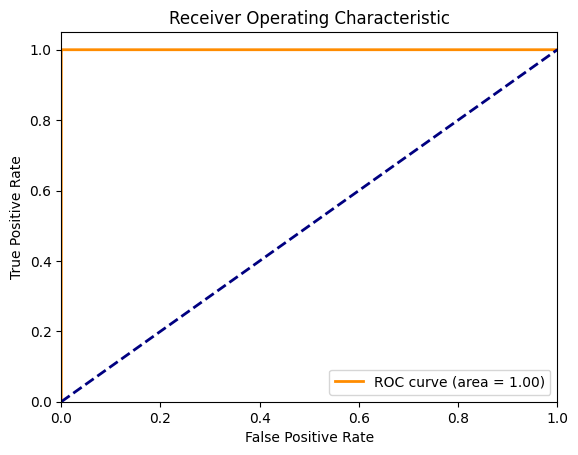

In [11]:
y_pred_proba = rf.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test.map({'BENIGN': 0, 'MALIGN': 1}), y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Nivel 2

Ahora queremos compactar nuestro dataset original a 3 classes, DDoS, PortScan y WebAttack.

In [16]:
X_2 = X[y != 'BENIGN']
y_2 = y[y != 'BENIGN']

target_classes = {
    "Web Attack - Brute Force": 50000,
    "Web Attack - XSS": 50000,
    "Web Attack - Sql Injection": 50000
}

smote = SMOTE(sampling_strategy=target_classes, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_2, y_2)

print(y_resampled.value_counts())

AttackType
PortScan                      158804
DDoS                          128025
Web Attack - Brute Force       50000
Web Attack - XSS               50000
Web Attack - Sql Injection     50000
Name: count, dtype: int64


In [17]:
y_resampled = y_resampled.apply(lambda x: 'WebAttack' if "Web Attack" in x else x)
print(y_resampled.value_counts())

AttackType
PortScan     158804
WebAttack    150000
DDoS         128025
Name: count, dtype: int64


Como los ataques pueden tener cierto tipo de similaridad entre ellos, y ya vimos en el estudio inicial que no hay relaciones lineal entre variables y variable objetivo. El nivel dos usaremos un modelo mas complejo, una NN. Las NN requieren de un preprocesamiento extra:

- **Datos normalizados**: Usaremos MinMaxScaler.

- **Evitar redundancia y ruido**: Si los resultados no son buenos, trataremos esto, ya que puede ser al haber hecho un oversampling tan fuerte.

- **Codificación de etiquetas**: Usaremos LabelEncoding.

In [24]:
scaler = MinMaxScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

X_resampled_scaled = pd.DataFrame(X_resampled_scaled, columns=X_resampled.columns)

X_resampled_scaled.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,436829.000000,4.368290e+05,436829.000000,436829.000000,436829.000000,436829.000000,436829.000000,436829.000000,436829.000000,436829.000000,...,436829.000000,436829.000000,436829.000000,436829.000000,436829.000000,436829.000000,436829.000000,436829.000000,436829.000000,436829.000000
mean,0.048726,5.696206e-02,0.015874,0.023876,0.008814,0.017548,0.077294,0.020820,0.054172,0.071048,...,0.018636,0.712515,0.011773,0.000004,0.011773,0.011772,0.029514,0.020427,0.037254,0.021774
std,0.139010,1.558565e-01,0.087120,0.083442,0.084829,0.063907,0.237774,0.039344,0.153388,0.225241,...,0.091734,0.182372,0.086864,0.001800,0.086866,0.086863,0.115330,0.122943,0.143324,0.101981
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001223,4.423681e-07,0.000000,0.008772,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.001223,4.932713e-03,0.009479,0.008772,0.000041,0.000033,0.003322,0.000000,0.008288,0.000000,...,0.000000,0.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.022940,4.471076e-02,0.009479,0.035088,0.000531,0.005890,0.033223,0.041667,0.029009,0.018794,...,0.019802,0.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
label_encoder = LabelEncoder()
y_resampled_encoded = label_encoder.fit_transform(y_resampled)
unique, counts = np.unique(y_resampled_encoded, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(128025), np.int64(1): np.int64(158804), np.int64(2): np.int64(150000)}


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled_encoded, test_size=0.2, random_state=42)


model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),  # Primera capa oculta con 128 nodos
    Dropout(0.3),  # Dropout para prevenir sobreajuste
    Dense(64, activation='relu'),  # Segunda capa oculta con 64 nodos
    Dropout(0.3),
    Dense(3, activation='softmax')  # Capa de salida para clasificación multiclase (3 clases)
])

# 6. Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',  # Para problemas multiclase
              metrics=['accuracy'])

# 7. Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# 8. Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

NameError: name 'Sequential' is not defined